In [2]:
import pandas as pd
import numpy as np
import requests
import datetime
import os
import matplotlib.pyplot as plt

In [3]:
def read_xls(file, sheet):
    
    try:
        df = pd.read_excel(file,sheet)
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [4]:
def calculate_bearing(d):
  dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
  ix = int(round(d / (360. / len(dirs))))
    
  return dirs[ix % len(dirs)]

In [5]:
df = read_xls("KW9D-11 APRS Raw Packets.xlsx","Telemetry")

In [6]:
df.sample(10)

,Date,Time,TZ,Path,GPS Time,GPS Epoch,GPS Time Delta (sec),Lat,Lon,Bearing,...,Ascent Speed (fps),Ascent Speed (mps),HDOP,Interior Temp ©,Interior Temp (F),Interior Pressure,Exterior Temp (C),Exterior Temp (F),Exterior Pressure,Relative Humidity
4,2022-04-29,10:26:44,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAO,KS9A-10:",152638h,55598,144,4034.88N,08856.54W,O355,...,9.638889,2.937933,00104H,30.6C,86.0,779.hPa,8.66C,47.48,782.hPa,0.5450
104,2022-04-29,12:53:13,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAO,W0CBL-1:",175307h,64387,72,4032.21N,08814.99W,O024,...,9.861111,3.005667,00090H,18.6C,64.4,6.11hPa,4.78C,40.46,14.7hPa,0.0065
105,2022-04-29,12:54:25,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,W9IPA-11:",175419h,64459,72,4032.29N,08814.81W,O077,...,11.069444,3.373967,00124H,18.8C,64.4,7.27hPa,4.05C,39.20,14.2hPa,0.0074
37,2022-04-29,11:13:32,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,W9PFD:",161326h,58406,72,4039.03N,08841.72W,O099,...,13.125000,4.000500,00395H,24.7C,75.2,244.hPa,-35.C,-31.00,257.hPa,0.1550
92,2022-04-29,12:36:25,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:",173619h,63379,144,4030.32N,08815.23W,O348,...,10.326389,3.147483,00284H,18.8C,64.4,14.9hPa,-2.8C,28.40,22.6hPa,0.0133
34,2022-04-29,11:09:56,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,W9RCA-10:",160950h,58190,72,4039.39N,08844.32W,O102,...,10.638889,3.242733,00130H,26.2C,78.8,282.hPa,-26.C,-14.80,290.hPa,0.1610
94,2022-04-29,12:38:49,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,KD0BQS-15:",173843h,63523,72,4030.33N,08815.42W,O013,...,12.083333,3.683000,00180H,19.0C,66.2,13.3hPa,-2.6C,28.40,20.9hPa,0.0140
17,2022-04-29,10:44:44,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,KC8RFE-2:",154438h,56678,72,4039.41N,08855.50W,O046,...,10.680556,3.255433,00147H,29.0C,84.2,534.hPa,-2.7C,28.40,538.hPa,0.3380
120,2022-04-29,13:28:02,CDT:,"KW9D-11>APLIGA,WIDE2-1,qAR,W9IPA-11:",182756h,66476,72,4031.73N,08804.00W,O101,...,-34.541667,-10.528300,00613H,14.0C,57.2,426.hPa,-13.C,8.60,490.hPa,0.6630
125,2022-04-29,13:37:38,CDT:,"KW9D-11>APLIGA,WA9RES*,WIDE2-1,qAR,KC8RFE-3:",183731h,67051,215,4034.09N,08803.23W,O292,...,-29.697674,-9.051851,00214H,15.9C,59.0,908.hPa,16.7C,60.80,963.hPa,0.4520


In [7]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity'],
      dtype='object')

In [8]:
df['I Pressure'] = df['Interior Pressure'].str[:4] + '0'
df['I Pressure'] = df['I Pressure'].astype(float)

In [9]:
df['Interior Temp C'] = df['Interior Temp ©'].str[:4].astype(float)

In [10]:
df['E Pressure'] = df['Exterior Pressure'].str[:4] + '0'
df['E Pressure'] = df['E Pressure'].astype(float)

In [11]:
df['Exterior Temp C'] = df['Exterior Temp (C)'].str[:4].astype(float)

In [12]:
df['Time'] = pd.to_datetime(df['GPS Time'].str[:6],format= '%H%M%S' ).dt.time

In [13]:
df['Cardinal Direction'] = df['Bearing'].str[1:].astype(int).apply(calculate_bearing)

In [14]:
df['HDOP (ft)'] = df['HDOP'].str[:5].astype(int)

In [15]:
df['Rate (fps)'] = df['Ascent Speed (fps)'].abs()
df['Rate (m/s)'] = df['Ascent Speed (mps)'].abs()

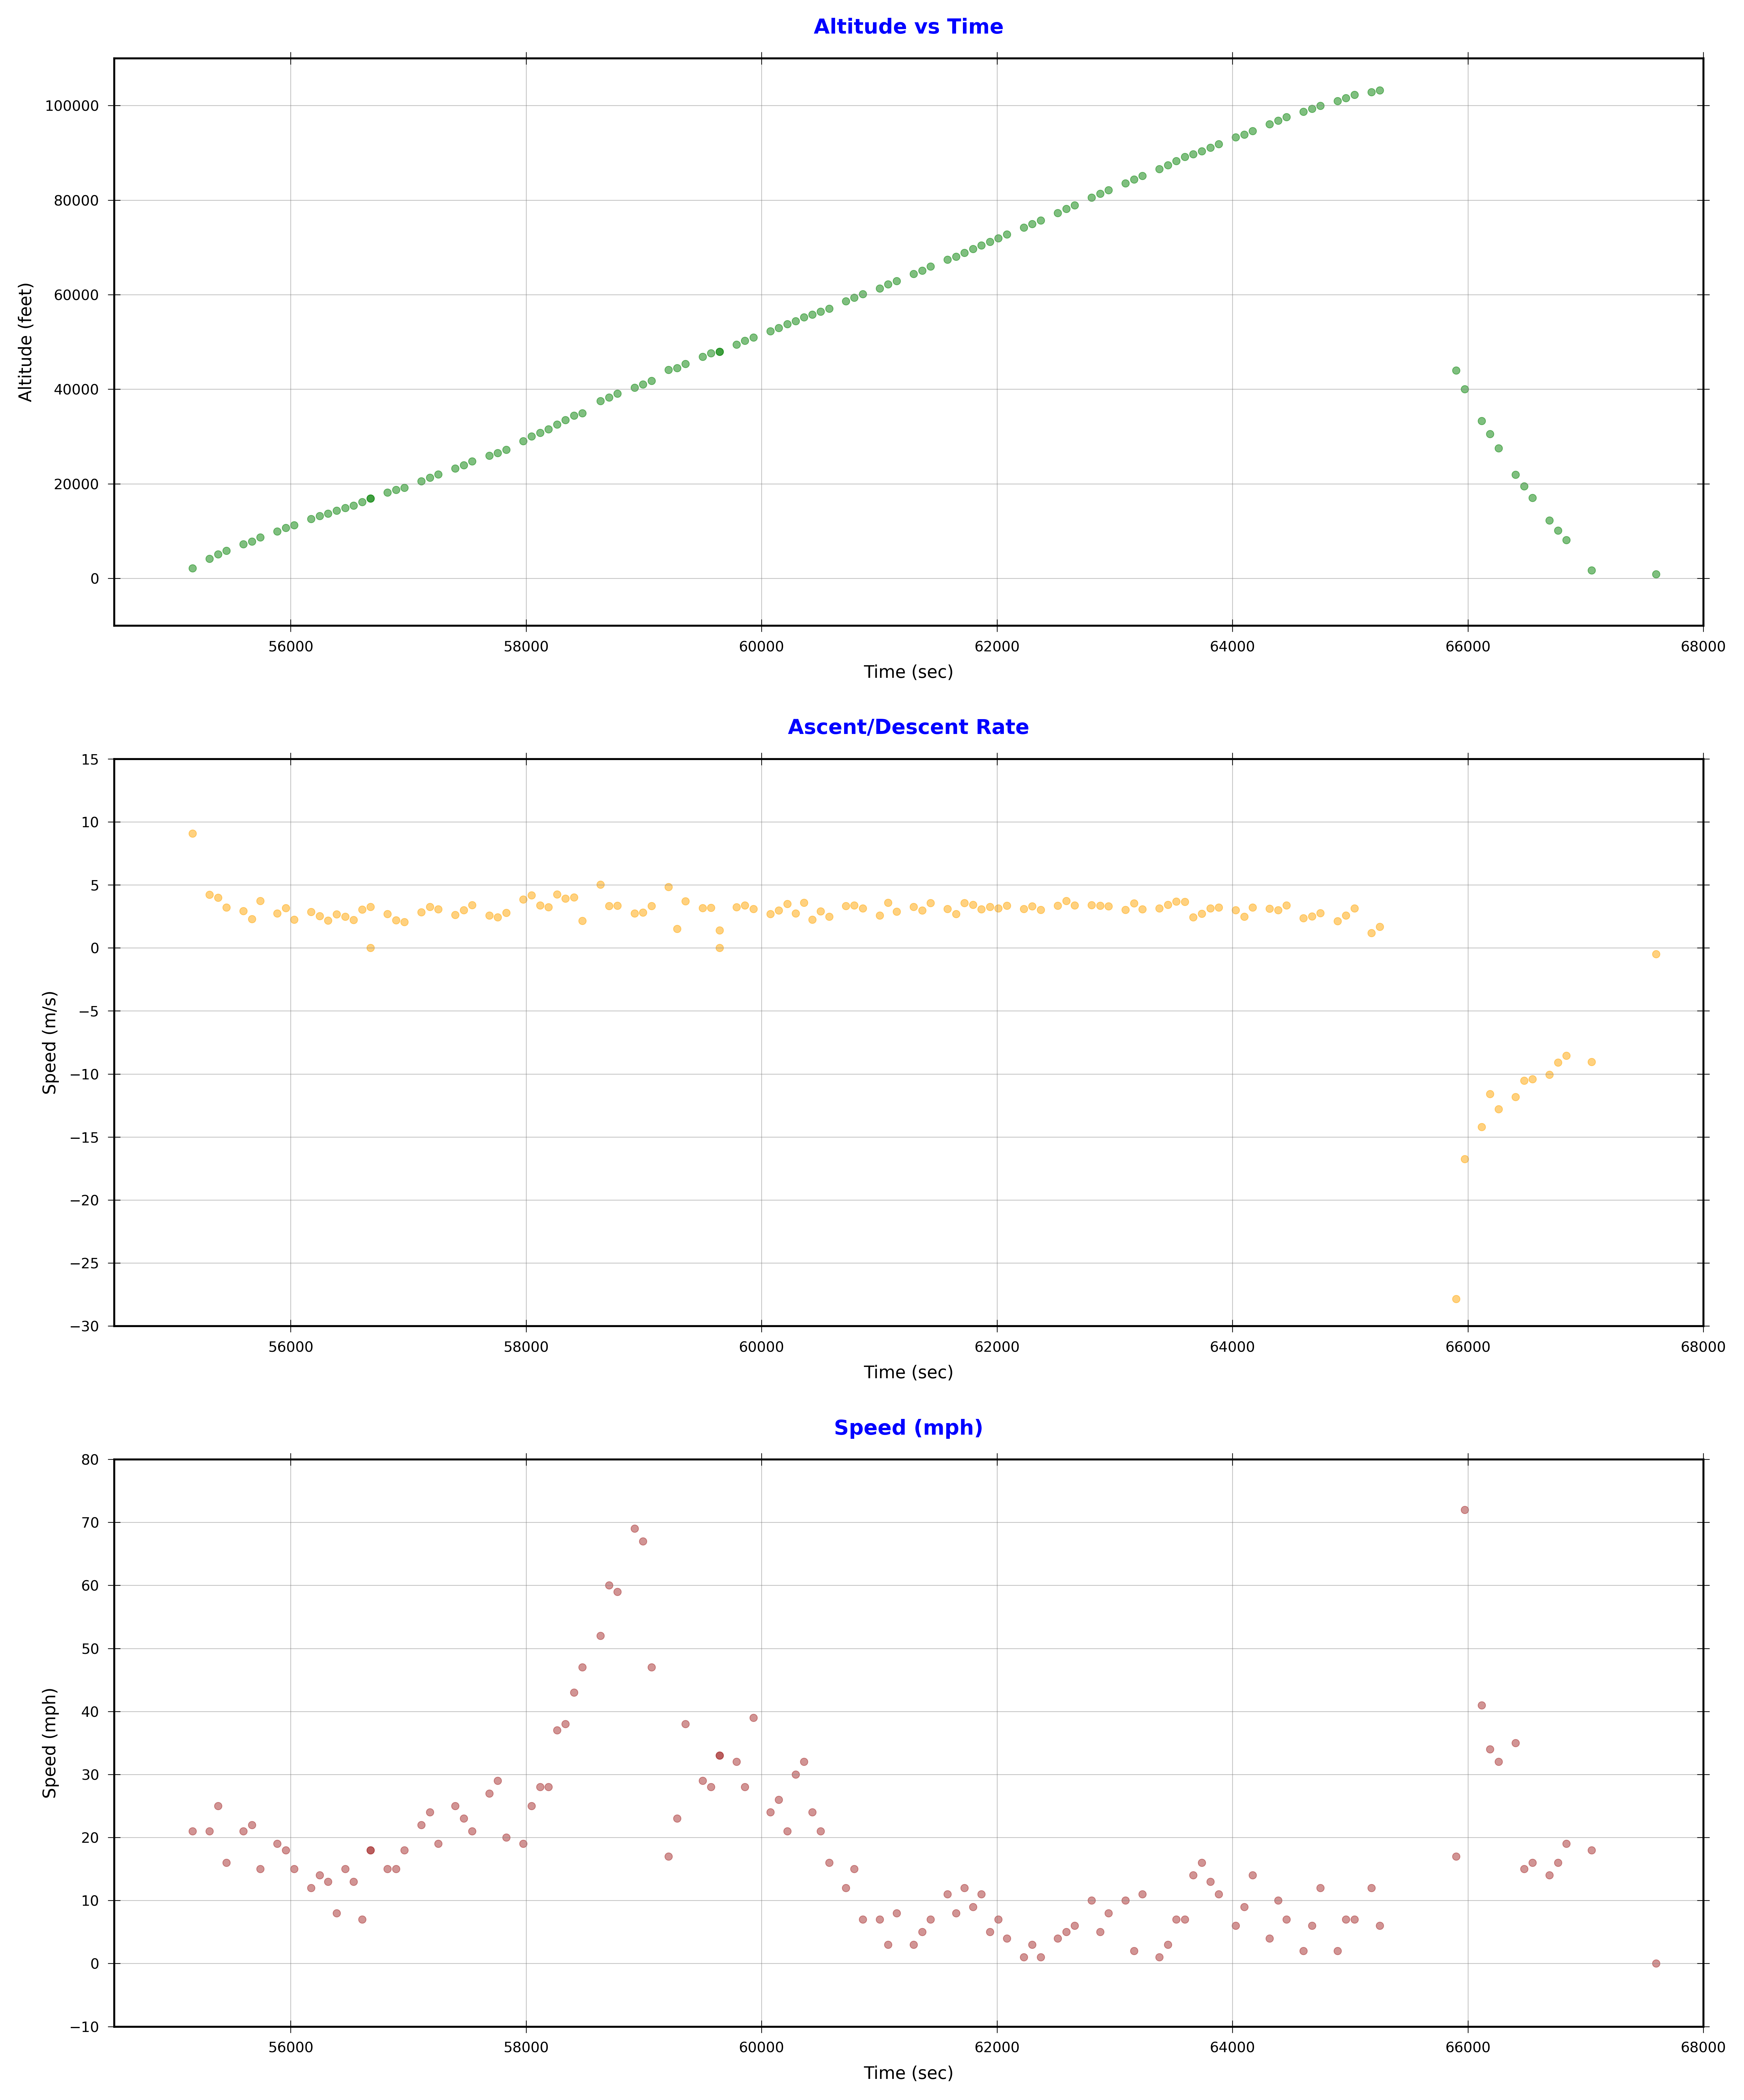

In [43]:
%matplotlib inline

plt.figure(dpi=600, figsize=(10,12))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('GPS Epoch', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (sec)', size='x-small')
plot1.set_ylabel('Altitude (feet)', size='x-small')
plot1.set_title('Altitude vs Time', color='blue', size='small', pad=10.0, weight='bold')
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([-10000,110000])
plot1.set_xlim([54500,68000])

plot2.scatter('GPS Epoch', 'Ascent Speed (mps)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5,linewidth=0.3)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Time (sec)', size='x-small')
plot2.set_ylabel('Speed (m/s)', size='x-small')
plot2.set_title('Ascent/Descent Rate', color='blue', size='small', pad=10.0, weight='bold')
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([-30,15])
plot2.set_xlim([54500,68000])

plot3.scatter('GPS Epoch', 'Speed (mph)', data=df, marker='.', color='brown', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Time (sec)', size='x-small')
plot3.set_ylabel('Speed (mph)', size='x-small')
plot3.set_title('Speed (mph)', color='blue', size='small', pad=10.0, weight='bold')
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([-10,80])
plot3.set_xlim([54500,68000])

plt.tight_layout(pad=1.5)
plt.show()

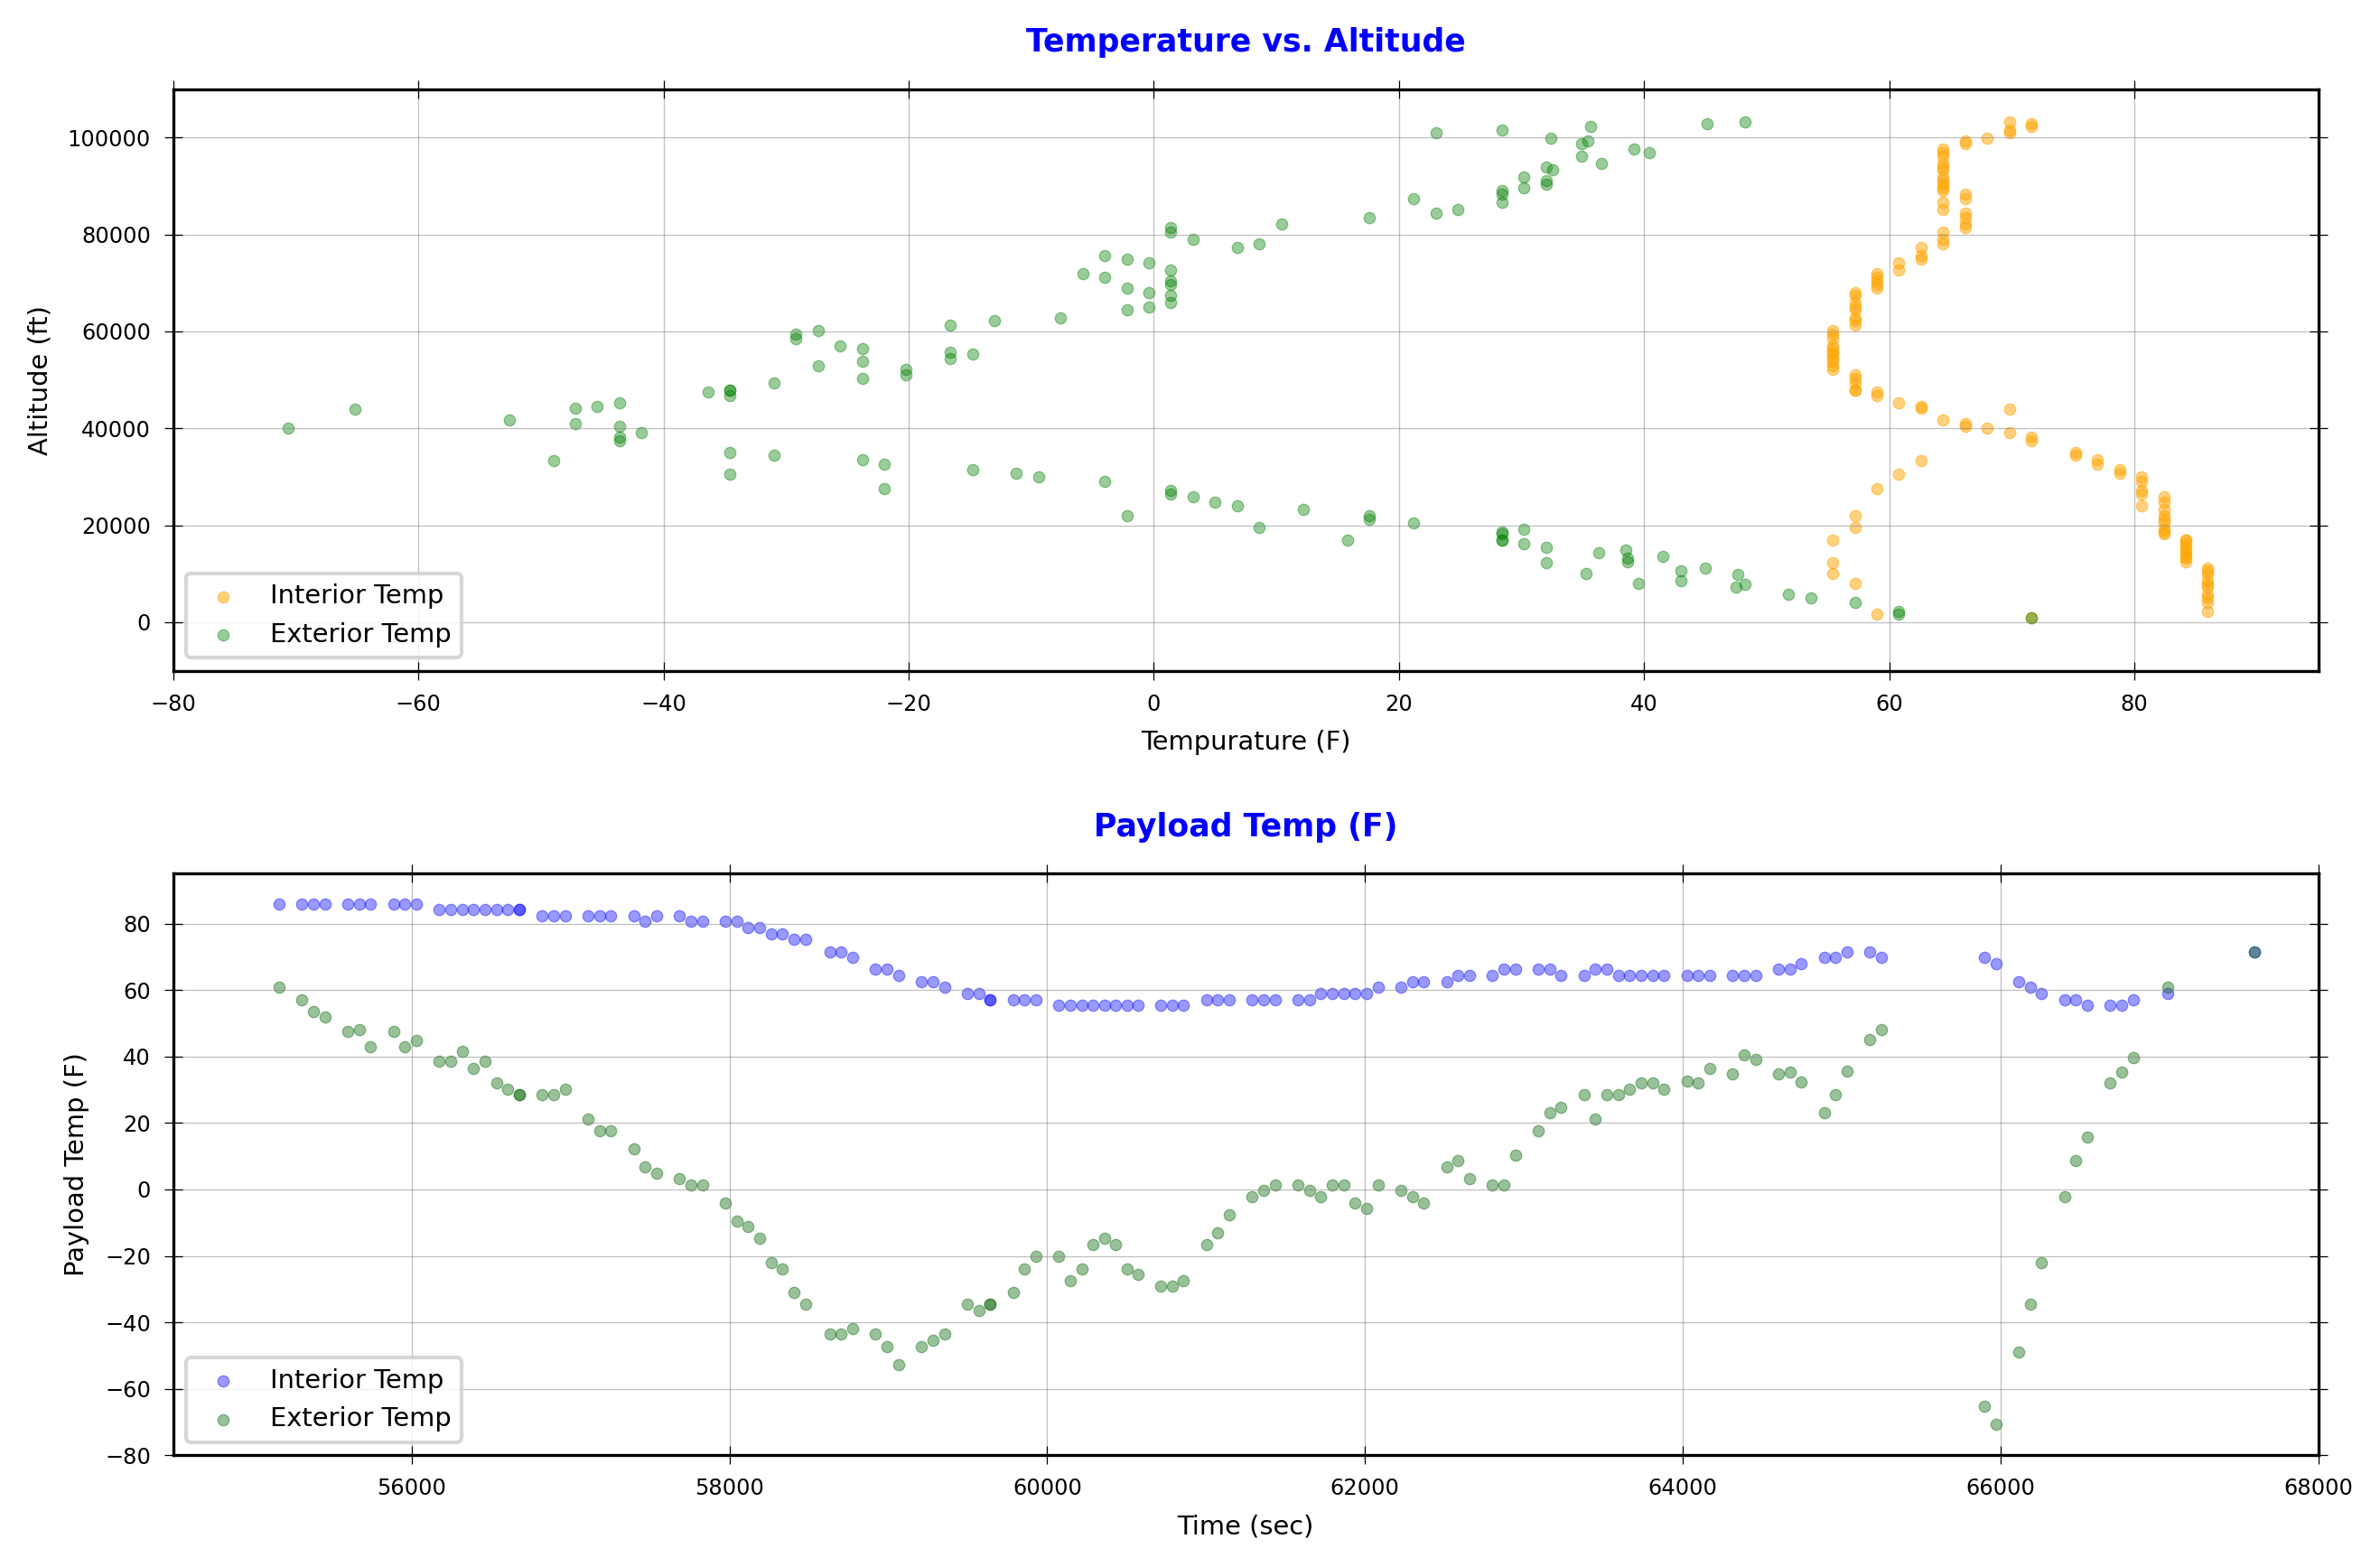

In [24]:
%matplotlib inline

plt.figure(dpi=300, figsize=(9,6))
plot4 = plt.subplot2grid((2,1),(0,0))
plot5 = plt.subplot2grid((2,1),(1,0))

plot4.scatter('Interior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot4.scatter('Exterior Temp (F)', 'Altitude (ft)', data=df, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot4.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot4.set_xlabel('Tempurature (F)', size='x-small')
plot4.set_ylabel('Altitude (ft)', size='x-small')
plot4.set_title('Temperature vs. Altitude', color='blue', size='small', pad=10.0, weight='bold')
plot4.grid(visible=True, which='both', linewidth=0.3)
plot4.set_xlim([-80,95])
plot4.set_ylim([-10000,110000])
plot4.legend(['Interior Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plot5.scatter('GPS Epoch', 'Interior Temp (F)', data=df, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Exterior Temp (F)', data=df, marker='.', color='darkgreen', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot5.set_xlabel('Time (sec)', size='x-small')
plot5.set_ylabel('Payload Temp (F)', size='x-small')
plot5.set_title('Payload Temp (F)', color='blue', size='small', pad=10.0, weight='bold')
plot5.grid(visible=True, which='both', linewidth=0.3)
plot5.set_ylim([-80,95])
plot5.set_xlim([54500,68000])
plot5.legend(['Interior Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plt.tight_layout(pad=1.5)
plt.show()

In [18]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)'],
      dtype='object')

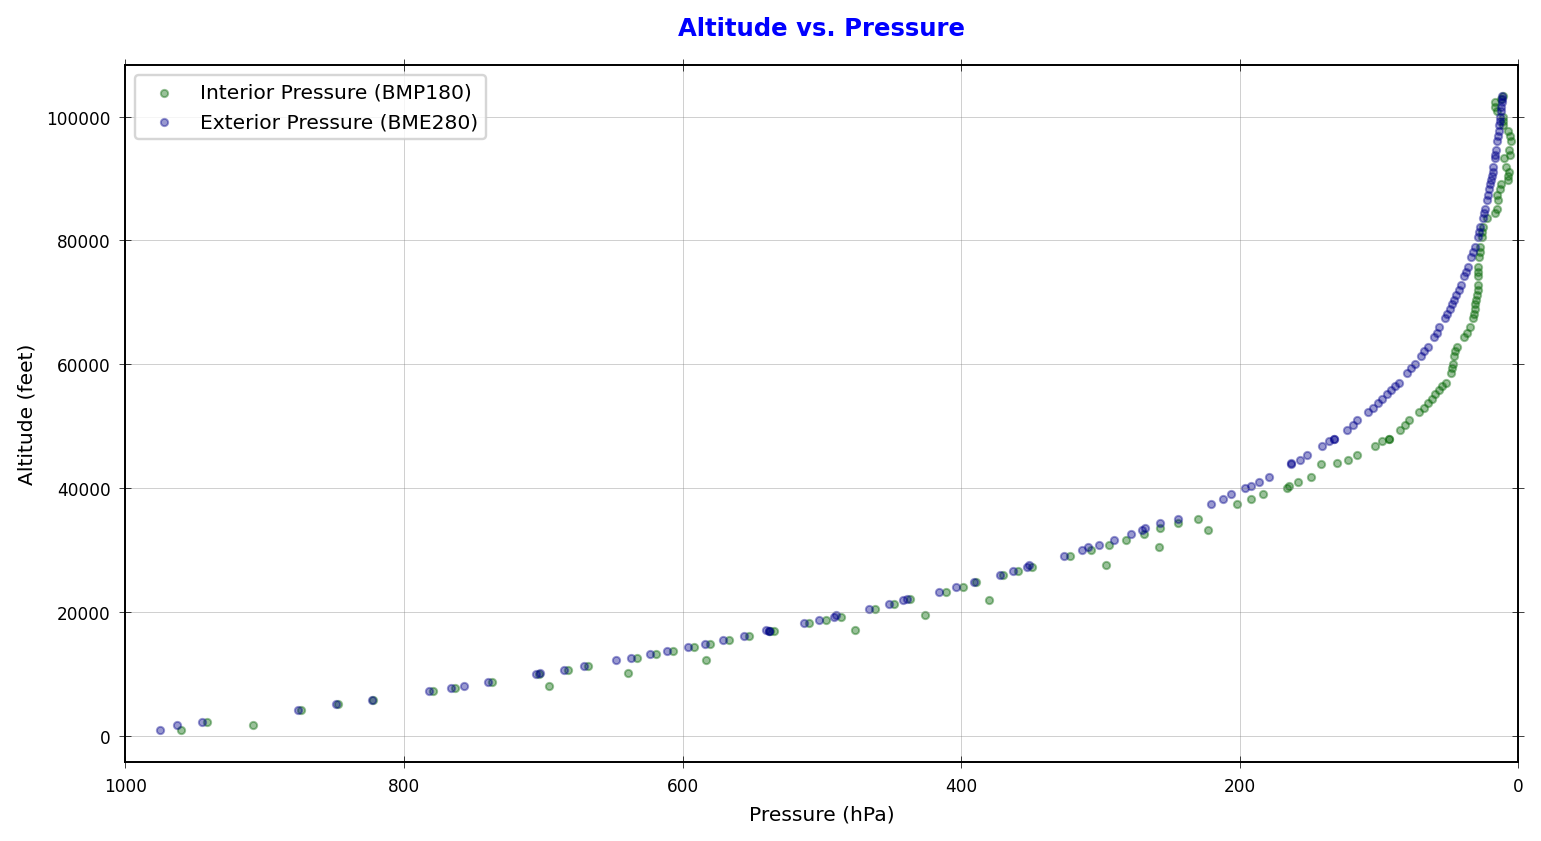

In [42]:
%matplotlib inline

plt.figure(dpi=175, figsize=(10,6))
plot1 = plt.subplot2grid((1,1),(0,0))
#plot2 = plt.subplot2grid((2,1),(1,0))

plot1.scatter('I Pressure', 'Altitude (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8,)
plot1.scatter('E Pressure', 'Altitude (ft)', marker='.', data=df, color='darkblue', alpha=0.4, linewidth=0.8,)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Altitude (feet)', size='small')
plot1.set_title('Altitude vs. Pressure', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.legend(['Interior Pressure (BMP180)', 'Exterior Pressure (BME280)'], fontsize='small', loc='upper left')
plot1.set_xlim([1000,0])

plt.tight_layout(pad=5.0)
plt.show()

In [20]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)'],
      dtype='object')

In [44]:
%matplotlib inline

plt.figure(dpi=800, figsize=(10,10))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('Altitude (ft)', 'HDOP (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Altitude (ft)', size='small')
plot1.set_ylabel('HDOP (ft)', size='small')
plot1.set_title('HDOP vs. Altitude', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('Speed (mph)', 'HDOP (ft)', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Speed (mph)', size='small')
plot2.set_ylabel('HDOP (ft)', size='small')
plot2.set_title('HDOP vs. Speed', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot2.grid(visible=True, which='both', linewidth=0.3)

plot3.scatter('Rate (fps)', 'HDOP (ft)', marker='.', data=df, color='orange', alpha=0.5, linewidth=0.8)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Ascent/Descent Rate (fps)', size='small')
plot3.set_ylabel('HDOP (ft)', size='small')
plot3.set_title('HDOP vs. Rate', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot3.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [45]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'GPS Time', 'GPS Epoch',
       'GPS Time Delta (sec)', 'Lat', 'Lon', 'Bearing', 'Speed (mph)',
       'Speed (m/s)', 'Altitude (ft)', 'Altitude (m)', 'Ascent Delta (ft)',
       'Ascent Speed (fps)', 'Ascent Speed (mps)', 'HDOP', 'Interior Temp ©',
       'Interior Temp (F)', 'Interior Pressure', 'Exterior Temp (C)',
       'Exterior Temp (F)', 'Exterior Pressure', 'Relative Humidity',
       'I Pressure', 'Interior Temp C', 'E Pressure', 'Exterior Temp C',
       'Cardinal Direction', 'HDOP (ft)', 'Rate (fps)', 'Rate (m/s)'],
      dtype='object')

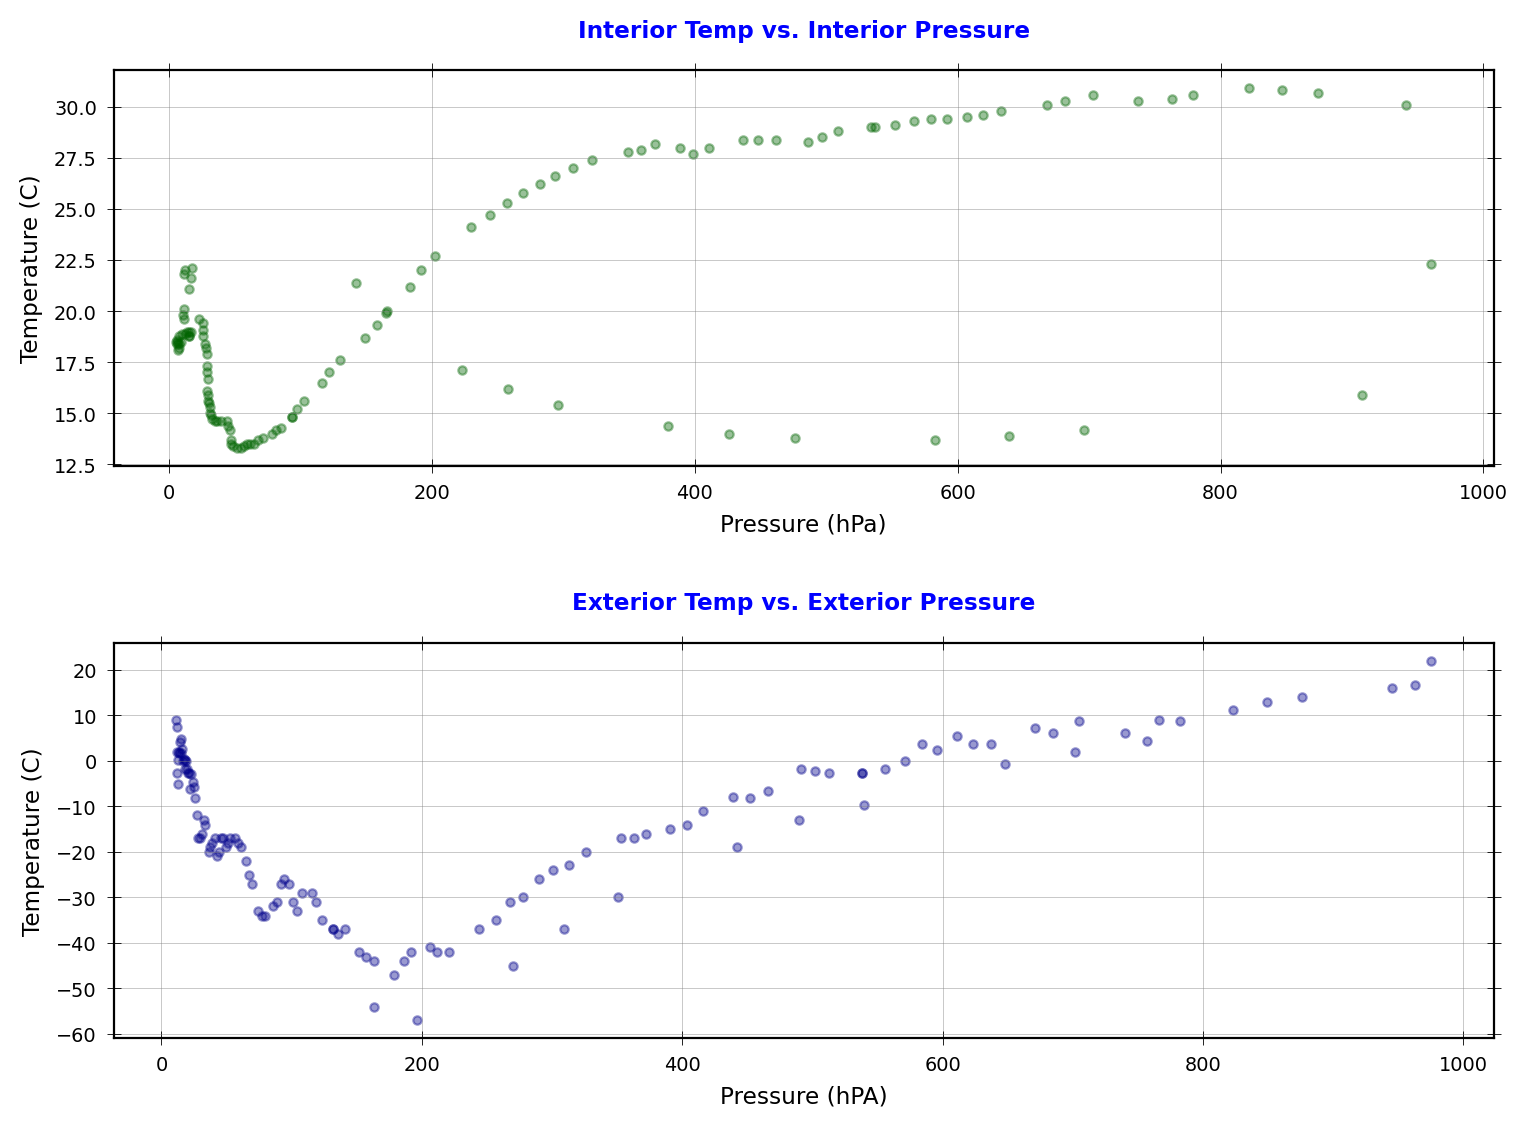

In [56]:
%matplotlib inline

plt.figure(dpi=200, figsize=(8,6))
plot1 = plt.subplot2grid((2,1),(0,0))
plot2 = plt.subplot2grid((2,1),(1,0))

plot1.scatter('I Pressure', 'Interior Temp C', marker='.', data=df, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Temperature (C)', size='small')
plot1.set_title('Interior Temp vs. Interior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plot2.scatter('E Pressure', 'Exterior Temp C', marker='.', data=df, color='darkblue', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Pressure (hPA)', size='small')
plot2.set_ylabel('Temperature (C)', size='small')
plot2.set_title('Exterior Temp vs. Exterior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot2.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()